# Wireframe Detection with LCNN

This notebook guides us through using LCNN, finds common usage patterns in the output data, visualizes the found features, and prototypes the needed data structures to effectively use this tool.

## Dependencies

First follow Yichao's guide to setup your conda environment.

```
conda create -y -n lcnn
source activate lcnn
# Replace cudatoolkit=10.1 with your CUDA version: https://pytorch.org/
conda install -y pytorch cudatoolkit=10.1 -c pytorch
conda install -y tensorboardx -c conda-forge
conda install -y pyyaml docopt matplotlib scikit-image opencv
```

Then you can create a Jupyter kernel by following these steps:

```
conda install ipykernel
conda deactivate
conda install -c conda-forge nb_conda_kernels
```

Then you should have a Python kernel called "Python \[conda env:lcnn\]" available in Jupyter Lab/Notebook. 

## Usage instructions

You'll first need the pretrained LCNN model, which is available from their Drive link here:

[Pretrained LCNN model](https://drive.google.com/file/d/1NvZkEqWNUBAfuhFPNGiCItjy4iU0UOy2)

The model should go in the `data/` directory with the `.pth.tar` extension, but feel free to rename it to a more logical filename.

You'll also need the [wireframe.yaml](https://github.com/zhou13/lcnn/blob/master/config/wireframe.yaml) file, also in your `data/` directory.

Finally, make sure you have your images available to load.

In [1]:
import os
import os.path as osp
import pprint
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to

import utils

# Modify the following variables based on what you want the code to do

In [2]:
# Workspace constants

# Relative directory for data (containing saved parameters, images, etc)
DATA_DIRECTORY = "../data"

# Filepaths
config_file = os.path.join(DATA_DIRECTORY, "wireframe.yaml")
model_file = os.path.join(DATA_DIRECTORY, "pretrained_lcnn.pth.tar")

# Determines if CPU ("") or GPU ("0", "1",...) will be used
gpu_devices = ""

# Additional variables
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

def c(x):
    return sm.to_rgba(x)

In [3]:
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

device_name = "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_devices
if torch.cuda.is_available():
    device_name = "cuda"
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(0)
    print("Let's use", torch.cuda.device_count(), "GPU(s)!")
else:
    print("CUDA is not available")
device = torch.device(device_name)
checkpoint = torch.load(model_file, map_location=device)

# Load model
model = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
)
model = MultitaskLearner(model)
model = LineVectorizer(model)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

def visualize(imname):
    print(f"Processing {imname}")
    im = skimage.io.imread(imname)
    if im.ndim == 2:
        im = np.repeat(im[:, :, None], 3, 2)
    im = im[:, :, :3]
    im_resized = skimage.transform.resize(im, (512, 512)) * 255
    image = (im_resized - M.image.mean) / M.image.stddev
    image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()
    with torch.no_grad():
        input_dict = {
            "image": image.to(device),
            "meta": [
                {
                    "junc": torch.zeros(1, 2).to(device),
                    "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                    "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                    "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                }
            ],
            "target": {
                "jmap": torch.zeros([1, 1, 128, 128]).to(device),
                "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
            },
            "mode": "testing",
        }
        H = model(input_dict)["preds"]

    lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
    scores = H["score"][0].cpu().numpy()
    for i in range(1, len(lines)):
        if (lines[i] == lines[0]).all():
            lines = lines[:i]
            scores = scores[:i]
            break

    # postprocess lines to remove overlapped lines
    diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
    nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

    for i, t in enumerate([0.94, 0.95, 0.96, 0.97, 0.98, 0.99]):
        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0, 0)
        for (a, b), s in zip(nlines, nscores):
            if s < t:
                continue
            plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
            plt.scatter(a[1], a[0], **PLTOPTS)
            plt.scatter(b[1], b[0], **PLTOPTS)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.imshow(im)
        plt.savefig(imname.replace(".png", f"-{t:.02f}.svg"), bbox_inches="tight")
        plt.show()
        plt.close()


{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 24000},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 6,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
                                    'lpos': 1},
                 'n_dyn_junc': 300,
                 'n_dy

Processing ../data/PurnurOffice/IMG_0861.jpg


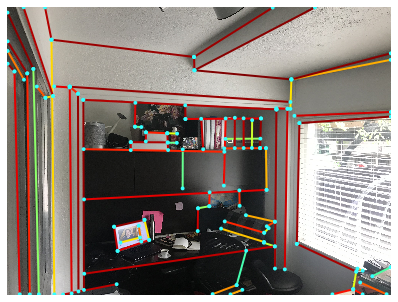

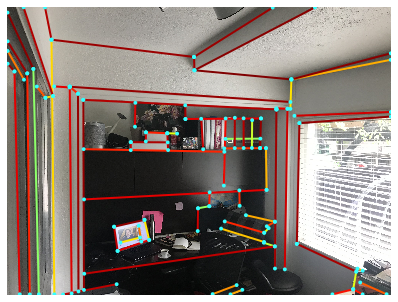

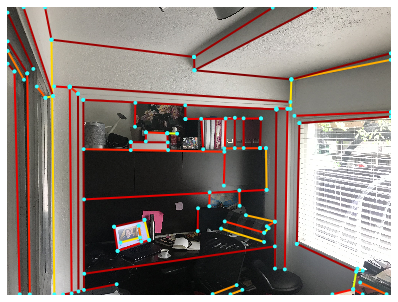

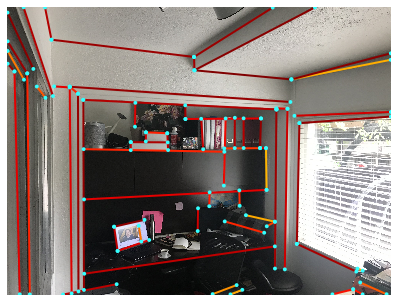

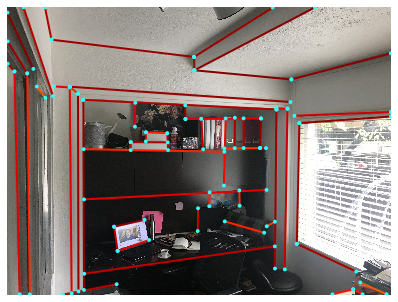

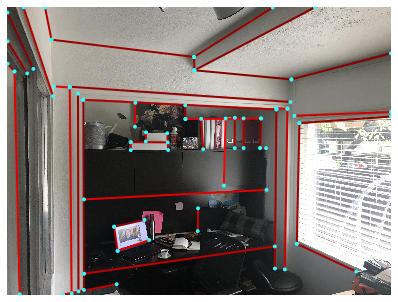

Processing ../data/PurnurOffice/IMG_0862.jpg


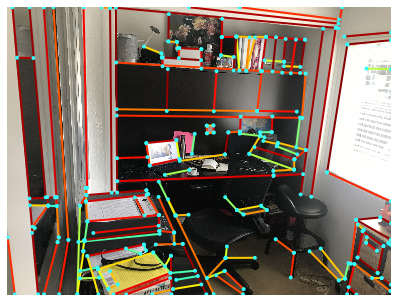

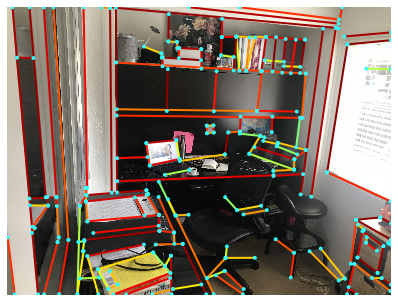

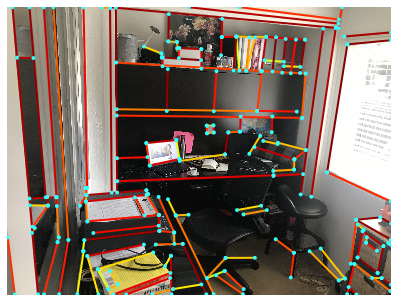

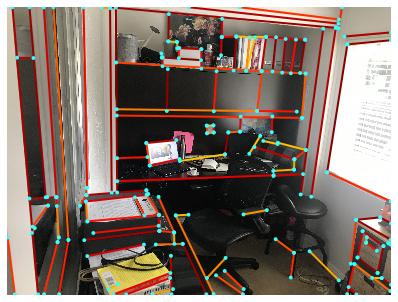

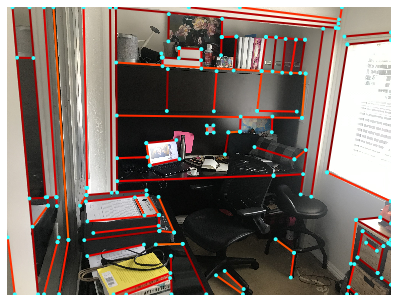

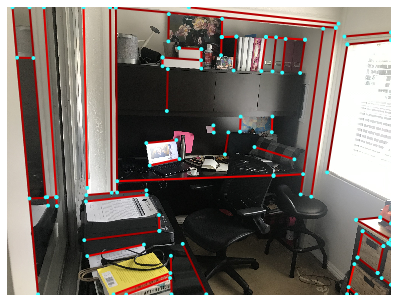

Processing ../data/PurnurOffice/IMG_0863.jpg


In [ ]:
images = []

images.append(utils.data("PurnurOffice/IMG_0861.jpg"))
images.append(utils.data("PurnurOffice/IMG_0862.jpg"))
images.append(utils.data("PurnurOffice/IMG_0863.jpg"))

for i in images:
    visualize(i)